# Filigree demo

This notebook demonstrates Filigree's Python API and User-Defined Function (UDF) support using Numba.

## Getting started

First, some essential imports:

In [1]:
import filigree
import os

Next, let's open an image file and display it in the notebook. We use the `to_pillow()` method to convert the Filigree image to a Pillow image so that it displays easily in the notebook.

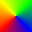

In [2]:
filigree_dir = os.path.dirname(os.path.abspath(filigree.__file__))
path = os.path.join(filigree_dir, 'tests', 'pngsuite', 'basn6a16.png')
basn6a16 = filigree.Image(path)
basn6a16.to_pillow()

## Invoking built-in kernels

We can invoke Filigree's built-in kernels by using the relevant methods. For example, to convert our image to greyscale:

In [3]:
basn6a16.apply_weighted_greyscale()

We should now see that the image has been transformed in-place:

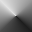

In [4]:
basn6a16.to_pillow()

Let's open the image again and invoke another built-in kernel:

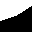

In [5]:
basn6a16 = filigree.Image(path)
basn6a16.binarize()
basn6a16.to_pillow()

## Using the Numba extension

First we'll demonstrate how the extension enables Filigree data structures to be used inside Numba `@cuda.jit`-annotated kernels.

The relevant imports are:

In [6]:
# For compiling Python to CUDA kernels
from numba import cuda
# Needed for passing Filigree Image objects to Numba kernels
from filigree.numba_extension import filigree_image_handler

Then we can define a kernel that operates on Filigree images. This kernel removes all non-red components.

In [7]:
# Function to transform an individual pixel
@cuda.jit
def red_filter(pixel):
    # Strip out green and blue components
    return pixel.r, 0, 0, pixel.a

# The "outer" kernel that we launch. The extension is necessary so that
# the relevant fields of the Image object can be marshalled by Numba.
@cuda.jit(extensions=[filigree_image_handler])
def my_transform(image):
    
    # Determine our thread's position in the grid and ensure we're
    # within the bounds of the image
    x, y = cuda.grid(2)
    if x >= image.width or y >= image.height:
        return
    
    # Load our pixel
    pixel = image[x, y]
    
    # Transform our pixel
    r, g, b, a = red_filter(pixel.values)
    
    # Write the transformed results back to memory
    pixel.r = r
    pixel.g = g
    pixel.b = b
    pixel.a = a

Let's load a new image:

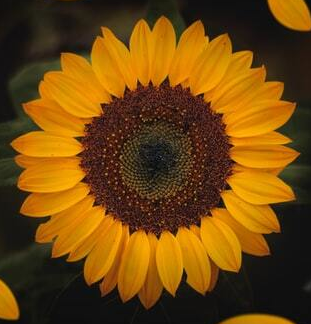

In [8]:
path = os.path.join(filigree_dir, 'tests', 'images', 'sunflower.png')
sunflower = filigree.Image(path)
sunflower.to_pillow()

Then launch our kernel to transform it:

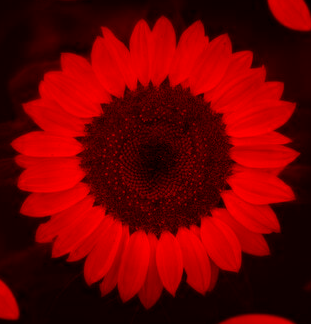

In [9]:
# Arbitrary choice of block size with a multiple of 32 threads
block_dim = (8, 8)
# Grid size is calculated based on the image dimensions and block size
grid_dim = ((sunflower.width // block_dim[0] + 1), (sunflower.height // block_dim[1] + 1))

# Launch our transformation
my_transform[grid_dim, block_dim](sunflower)

# View the result
sunflower.to_pillow()

This should look red.

### Using the UDF launcher

The example above works, but it still requires the author of a transformation to know how to write a CUDA kernel, and launch it in an appropriate manner. The Filigree Numba extension's launch API abstracts this away, enabling the user to write only the Python transformation function independently of any CUDA code.

Let's look at another example, this time using the `apply_pixel_udf()` UDF compiler / launcher. This example computes the intensity of each pixel and then filters it through a single channel (in this case red):

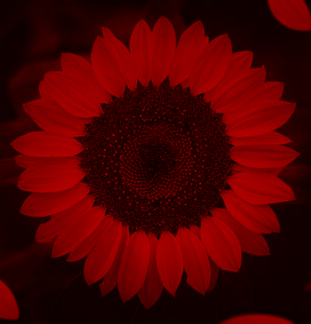

In [10]:
from numba import float32

# UDF definition
def redize_udf(pixel):
    weighted = (
        float32(0.299) * pixel.r +
        float32(0.587) * pixel.g +
        float32(0.114) * pixel.b
    )
    return weighted, 0, 0, 1

# Open a new image and apply the UDF to it
sunflower = filigree.Image(path)
sunflower.apply_pixel_udf(redize_udf)

# Display the result
sunflower.to_pillow()

Note that this looks slightly different to the result from the red filter above, which performed a different computation. We can define other UDFs to transform the image in different ways. A couple more examples:

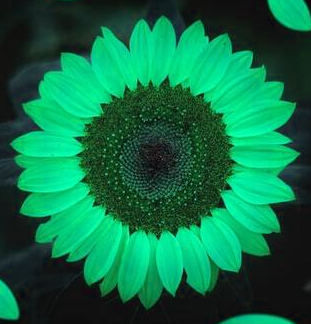

In [11]:
def rotate_channels(pixel):
    return pixel.b, pixel.r, pixel.g, pixel.a

# Open a new image and apply the UDF to it
sunflower = filigree.Image(path)
sunflower.apply_pixel_udf(rotate_channels)

# Display the result
sunflower.to_pillow()

### Another UDF launcher API

The `apply_pixel_udf()` API is very simple, but doesn't allow spatially-dependent transformations to be implemented. The next example shows how to do this, and demonstrates that an application can have multiple UDF APIs to support different use cases.

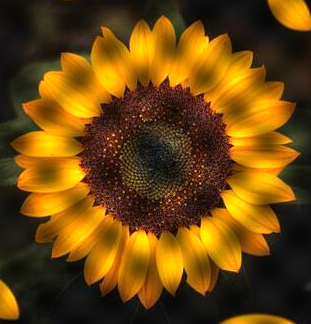

In [12]:
import math

def darken_spots(pixel, x, y):
    f = (2 - (math.sin(x / 10) * math.sin(y / 10))) / 2
    return pixel.r * f, pixel.g * f, pixel.b * f, pixel.a

# Open a new image and apply the UDF to it
sunflower = filigree.Image(path)
sunflower.apply_located_pixel_udf(darken_spots)

# Display the result
sunflower.to_pillow()

### Example from the presentation

This final example demonstrates execution of the use case from the GTC presentation, highlighting towards the centre of the image.

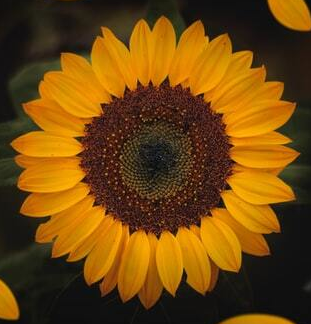

In [13]:
# Load original image
sunflower = filigree.Image(path)
sunflower.to_pillow()

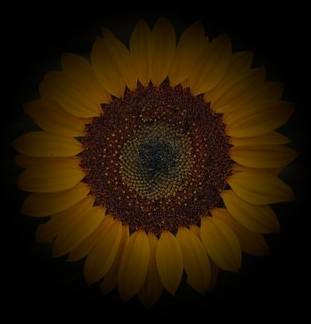

In [14]:
center_x = sunflower.width / 2
center_y = sunflower.height // 2
radius = max(center_x, center_y)

def highlight_center(pixel, x, y):
    distance_from_center = math.sqrt(
        abs(x - center_x)**2 + abs(y - center_y)**2)
    
    # Weight pixels according to distance from centre
    w = 1 - (distance_from_center / radius)
    
    # Apply weight to each RGB component
    return pixel.r * w, pixel.g * w, pixel.b * w, pixel.a

sunflower.apply_located_pixel_udf(highlight_center)
sunflower.to_pillow()